In [15]:
# %% [markdown]
# # Exploratory Data Analysis (EDA) 
# 
# 
# | **7️ Pairplot‑uri selecționate** | Relații bivariate + KDE diag. Salvat în `results/plots/`. |
# | **8️ QQ‑plots** | Verifică normalitatea principalelor variabile; PNG‑uri individuale. |
# | **9️ PCA + Clusterizare k‑means (k=2)** | Scree‑plot + proiecție 2D cu culori pe cluster. |
# 
# 
# ---
# %%
# 1️ Setup – importuri & căi
import sys
from pathlib import Path
from typing import List
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

BASE_DIR = Path("D:/Disertatie/1.database_performance_analysis").resolve()

DATA_DIR      = BASE_DIR / "data"
RAW_DIR       = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
METADATA_DIR  = DATA_DIR / "metadata"

RESULTS_DIR = BASE_DIR / "results"
TABLES_DIR  = RESULTS_DIR / "tables"
PLOTS_DIR   = RESULTS_DIR / "plots"

RAW_FILES = {
    "no_index"    : RAW_DIR / "queries_no_index.csv",
    "with_index"  : RAW_DIR / "queries_with_index.csv",
    "no_shards"   : RAW_DIR / "queries_no_shards.csv",
    "with_shards" : RAW_DIR / "queries_with_shards.csv",
}

plt.rcParams["figure.dpi"] = 110
sns.set(style="whitegrid")

for p in [TABLES_DIR, PLOTS_DIR, PROCESSED_DIR, METADATA_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# %%
# 2️ Încarcă & pregătește datele
idx    = pd.read_csv(RAW_FILES["with_index"],   low_memory=False)
no     = pd.read_csv(RAW_FILES["no_index"],     low_memory=False)
sh_idx = pd.read_csv(RAW_FILES["with_shards"],  low_memory=False)
sh_no  = pd.read_csv(RAW_FILES["no_shards"],    low_memory=False)

for df in [idx, no, sh_idx, sh_no]:
    df["query_id"] = df["query_id"].astype(str)

base_cols = ["query_id", "query_text", "documents_returned"]

idx2 = idx.rename(columns={"execution_time_ms": "exec_time_index"})
no2  = no .rename(columns={"execution_time_ms": "exec_time_no_index"})
merged_index = (
    idx2[base_cols + ["exec_time_index"]]
    .merge(no2[base_cols + ["exec_time_no_index"]], on="query_id", how="inner", suffixes=("_idx", "_no"))
)
merged_index["time_saved_ms"]   = merged_index["exec_time_no_index"] - merged_index["exec_time_index"]
merged_index["pct_improvement"] = merged_index["time_saved_ms"] / merged_index["exec_time_no_index"] * 100

sh_idx2 = sh_idx.rename(columns={"execution_time_ms": "exec_time_shards"})
sh_no2  = sh_no .rename(columns={"execution_time_ms": "exec_time_no_shards"})
merged_shards = (
    sh_idx2[base_cols + ["exec_time_shards"]]
    .merge(sh_no2[base_cols + ["exec_time_no_shards"]], on="query_id", how="inner", suffixes=("_sh", "_nsh"))
)
merged_shards["time_saved_ms"]   = merged_shards["exec_time_no_shards"] - merged_shards["exec_time_shards"]
merged_shards["pct_improvement"] = merged_shards["time_saved_ms"] / merged_shards["exec_time_no_shards"] * 100

# %%
# 3️ Rutină de bază pentru statistici rapide

def quick_eda(df: pd.DataFrame, name: str) -> pd.DataFrame:
    print(f"\n=== {name} ===  ({df.shape[0]:,} rows × {df.shape[1]} cols)")
    for k, v in df.dtypes.value_counts().items():
        print(f"  {k}: {v}")
    n_null_cols = (df.isna().sum() > 0).sum()
    print(f"Columns with nulls: {n_null_cols}/{len(df.columns)}")
    nums = df.select_dtypes(include=[np.number])
    desc = nums.describe().T
    desc["median"] = nums.median()
    desc["n_null"] = nums.isna().sum()
    desc["n_unique"] = nums.nunique()
    return desc


In [28]:
# %%
# 3️ Construcție *merged* pentru index/no‑index & shards/no‑shards
base_cols = ["query_id", "query_text", "documents_returned"]

idx2 = idx.rename(columns={"execution_time_ms": "exec_time_index"})
no2  = no .rename(columns={"execution_time_ms": "exec_time_no_index"})
merged_index = (
    idx2[base_cols + ["exec_time_index"]]
    .merge(no2[base_cols + ["exec_time_no_index"]], on="query_id", how="inner", suffixes=("_idx", "_no"))
)
merged_index["time_saved_ms"]   = merged_index["exec_time_no_index"] - merged_index["exec_time_index"]
merged_index["pct_improvement"] = merged_index["time_saved_ms"] / merged_index["exec_time_no_index"] * 100

sh_idx2 = sh_idx.rename(columns={"execution_time_ms": "exec_time_shards"})
sh_no2  = sh_no .rename(columns={"execution_time_ms": "exec_time_no_shards"})
merged_shards = (
    sh_idx2[base_cols + ["exec_time_shards"]]
    .merge(sh_no2[base_cols + ["exec_time_no_shards"]], on="query_id", how="inner", suffixes=("_sh", "_nsh"))
)
merged_shards["time_saved_ms"]   = merged_shards["exec_time_no_shards"] - merged_shards["exec_time_shards"]
merged_shards["pct_improvement"] = merged_shards["time_saved_ms"] / merged_shards["exec_time_no_shards"] * 100


In [29]:
def quick_eda(df: pd.DataFrame, name: str) -> pd.DataFrame:
    print(f"\n=== {name} ===  ({df.shape[0]:,} rows × {df.shape[1]} cols)")
    for k, v in df.dtypes.value_counts().items():
        print(f"  {k}: {v}")
    nulls = df.isna().sum()
    if nulls.any():
        print("Nulls (top 10):\n", nulls.sort_values(ascending=False).head(10))
    print("Duplicates:", df.duplicated().sum())
    nums = df.select_dtypes(include=[np.number])
    desc = nums.describe().T
    desc["median"]   = nums.median()
    desc["n_null"]   = nums.isna().sum()
    desc["n_unique"] = nums.nunique()
    print(desc.head(10).round(3))
    return desc

In [30]:
# %%
# 5️ Rulează EDA & exportă
stats_map = {
    "with_index"    : quick_eda(idx,            "With Index (raw)"),
    "no_index"      : quick_eda(no,             "No Index (raw)"),
    "merged_index"  : quick_eda(merged_index,   "Merged Index"),
    "with_shards"   : quick_eda(sh_idx,         "With Shards (raw)"),
    "no_shards"     : quick_eda(sh_no,          "No Shards (raw)"),
    "merged_shards" : quick_eda(merged_shards,  "Merged Shards"),
}

for tag, df_stats in stats_map.items():
    df_stats.to_csv(TABLES_DIR / f"eda_{tag}_stats.csv")
print("\n EDA CSV‑uri salvate în", TABLES_DIR)


=== With Index (raw) ===  (122 rows × 6 cols)
  object: 4
  int64: 2
Duplicates: 0
                    count      mean        std  min     25%     50%     75%  \
execution_time_ms   122.0    65.311     33.910  6.0    39.0    83.0    87.0   
documents_returned  122.0  2902.852  22558.477  1.0  1000.0  1000.0  1000.0   

                         max  median  n_null  n_unique  
execution_time_ms      161.0    83.0       0        51  
documents_returned  250000.0  1000.0       0         7  

=== No Index (raw) ===  (122 rows × 6 cols)
  object: 4
  int64: 2
Duplicates: 0
                    count      mean        std  min      25%     50%      75%  \
execution_time_ms   122.0    66.131     37.331  6.0    40.25    81.0    85.75   
documents_returned  122.0  2902.852  22558.477  1.0  1000.00  1000.0  1000.00   

                         max  median  n_null  n_unique  
execution_time_ms      225.0    81.0       0        53  
documents_returned  250000.0  1000.0       0         7  

=== Merge

In [31]:
# Debug info pentru investigație
print(f"sh_idx rows: {sh_idx.shape[0]}")
print(f"sh_no rows: {sh_no.shape[0]}")
print(f"merged_shards rows: {merged_shards.shape[0]}")

# Verifică dacă dimensiunile sh_idx și sh_no sunt egale
if sh_idx.shape[0] != sh_no.shape[0]:
    print("❌ Inconsistency between sh_idx and sh_no")
    print(f"Difference: {abs(sh_idx.shape[0] - sh_no.shape[0])} rows")

# Verifică merge operation
if merged_shards.shape[0] != sh_idx.shape[0]:
    print("❌ Merge operation failed or filtered data") 

sh_idx rows: 118
sh_no rows: 122
merged_shards rows: 10
❌ Inconsistency between sh_idx and sh_no
Difference: 4 rows
❌ Merge operation failed or filtered data


In [32]:
# 1. Verifică join keys
print("=== JOIN KEYS ANALYSIS ===")
print(f"sh_idx join columns: {sh_idx.columns.tolist()}")
print(f"sh_no join columns: {sh_no.columns.tolist()}")

# 2. Verifică valorile comune pentru join
if 'your_join_key' in sh_idx.columns:  # înlocuiește cu coloana ta de join
    common_keys = set(sh_idx['your_join_key']) & set(sh_no['your_join_key'])
    print(f"Common join values: {len(common_keys)}")
    print(f"sh_idx unique keys: {sh_idx['your_join_key'].nunique()}")
    print(f"sh_no unique keys: {sh_no['your_join_key'].nunique()}")

# 3. Verifică NULL values în join keys
for col in sh_idx.columns:
    if sh_idx[col].isna().any() or sh_no[col].isna().any():
        print(f"NULL values in {col}: sh_idx={sh_idx[col].isna().sum()}, sh_no={sh_no[col].isna().sum()}")

# 4. Test outer merge
outer_merge = pd.merge(sh_idx, sh_no, how='outer', indicator=True)
print(outer_merge['_merge'].value_counts())

=== JOIN KEYS ANALYSIS ===
sh_idx join columns: ['query_id', 'query_text', 'execution_time_ms', 'status', 'documents_returned', 'timestamp']
sh_no join columns: ['query_id', 'query_text', 'execution_time_ms', 'status', 'documents_returned', 'timestamp']
NULL values in query_text: sh_idx=108, sh_no=0
NULL values in execution_time_ms: sh_idx=108, sh_no=0
NULL values in status: sh_idx=108, sh_no=0
NULL values in documents_returned: sh_idx=108, sh_no=0
NULL values in timestamp: sh_idx=108, sh_no=0
_merge
right_only    122
left_only     118
both            0
Name: count, dtype: int64


In [33]:
# %%
# 4️ Advanced EDA helpers

def plot_null_heatmap(df: pd.DataFrame, name: str):
    if not df.isna().any().any():
        return
    plt.figure(figsize=(min(12, len(df.columns)*0.3), 6))
    sns.heatmap(df.isna(), cbar=False)
    plt.title(f"Missing Values – {name}")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"null_heatmap_{name}.png")
    plt.close()


def plot_corr_heatmap(df: pd.DataFrame, name: str):
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] < 2:
        return
    plt.figure(figsize=(10, 8))
    corr = num.corr(method="spearman")
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Spearman Correlation – {name}")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"corr_heatmap_{name}.png")
    plt.close()


def plot_hist_box(df: pd.DataFrame, name: str):
    num = df.select_dtypes(include=[np.number])
    if num.empty:
        return
    cols = list(num.columns)
    per_fig = 15
    pages = math.ceil(len(cols)/per_fig)
    for pg in range(pages):
        subset = cols[pg*per_fig:(pg+1)*per_fig]
        n = len(subset)
        ncols = 3
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
        axes = axes.ravel()
        for i, col in enumerate(subset):
            sns.histplot(num[col], ax=axes[i], kde=True)
            axes[i].set_title(col)
        for ax in axes[n:]:
            ax.remove()
        fig.suptitle(f"Histograms – {name} (page {pg+1})", y=1.02)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"hist_{name}_p{pg+1}.png")
        plt.close()

        # Boxplots
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
        axes = axes.ravel()
        for i, col in enumerate(subset):
            sns.boxplot(x=num[col], ax=axes[i])
            axes[i].set_title(col)
        for ax in axes[n:]:
            ax.remove()
        fig.suptitle(f"Boxplots – {name} (page {pg+1})", y=1.02)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"box_{name}_p{pg+1}.png")
        plt.close()


def outlier_report(df: pd.DataFrame, name: str):
    num = df.select_dtypes(include=[np.number])
    out_data = []
    for col in num.columns:
        q1, q3 = num[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (num[col] < lower) | (num[col] > upper)
        if mask.any():
            out_data.append({"column": col, "n_outliers": int(mask.sum())})
    if out_data:
        pd.DataFrame(out_data).to_csv(TABLES_DIR / f"outliers_{name}.csv", index=False)


def advanced_eda(df: pd.DataFrame, tag: str, printable_name: str):
    desc = quick_eda(df, printable_name)
    desc.to_csv(TABLES_DIR / f"eda_{tag}_stats.csv")
    plot_null_heatmap(df, tag)
    plot_corr_heatmap(df, tag)
    plot_hist_box(df, tag)
    outlier_report(df, tag)
    print(f"Advanced EDA complete → CSV + PNG pentru {tag}\n")


In [34]:
# %%
# 5️ Rulează EDA pe toate seturile
eda_targets = [
    (idx, "with_index", "With Index (raw)"),
    (no,  "no_index", "No Index (raw)"),
    (merged_index, "merged_index", "Merged Index"),
    (sh_idx, "with_shards", "With Shards (raw)"),
    (sh_no, "no_shards", "No Shards (raw)"),
    (merged_shards, "merged_shards", "Merged Shards"),
]

for df, tag, pname in eda_targets:
    advanced_eda(df, tag, pname)

print("\n  Plot‑uri salvate în", PLOTS_DIR)
print(" Tabele salvate în", TABLES_DIR)



=== With Index (raw) ===  (122 rows × 6 cols)
  object: 4
  int64: 2
Duplicates: 0
                    count      mean        std  min     25%     50%     75%  \
execution_time_ms   122.0    65.311     33.910  6.0    39.0    83.0    87.0   
documents_returned  122.0  2902.852  22558.477  1.0  1000.0  1000.0  1000.0   

                         max  median  n_null  n_unique  
execution_time_ms      161.0    83.0       0        51  
documents_returned  250000.0  1000.0       0         7  
Advanced EDA complete → CSV + PNG pentru with_index


=== No Index (raw) ===  (122 rows × 6 cols)
  object: 4
  int64: 2
Duplicates: 0
                    count      mean        std  min      25%     50%      75%  \
execution_time_ms   122.0    66.131     37.331  6.0    40.25    81.0    85.75   
documents_returned  122.0  2902.852  22558.477  1.0  1000.00  1000.0  1000.00   

                         max  median  n_null  n_unique  
execution_time_ms      225.0    81.0       0        53  
documents_retu

In [35]:
# %%
# 6️ Smoke‑tests
assert all(d.shape[0] > 0 for d,_,_ in eda_targets), "Cel puțin un DataFrame este gol!"
print("Smoke tests passed ")


Smoke tests passed 


In [36]:
pairplot_vars = [
    "exec_time_index", "exec_time_no_index", "exec_time_shards", "exec_time_no_shards",
    "documents_returned", "time_saved_ms", "pct_improvement"
]

for df, tag, _ in eda_targets:
    cols_available = [c for c in pairplot_vars if c in df.columns]
    if len(cols_available) < 2:
        continue
    sns.pairplot(df[cols_available], diag_kind="kde")
    plt.suptitle(f"Pairplot – {tag}", y=1.02)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"pairplot_{tag}.png")
    plt.close()


In [37]:
# %%
# 8️ QQ‑plots pentru variabile numerice principale
qq_vars = ["exec_time_index", "exec_time_no_index", "exec_time_shards", "exec_time_no_shards"]
for df, tag, _ in eda_targets:
    for col in qq_vars:
        if col not in df.columns:
            continue
        plt.figure(figsize=(4,4))
        qqplot(df[col].dropna(), line="s", ax=plt.gca())
        plt.title(f"QQ‑Plot {col} – {tag}")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"qq_{tag}_{col}.png")
        plt.close()


C:\Users\Denisa\AppData\Local\Temp\ipykernel_1584\650137976.py:11: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Denisa\AppData\Local\Temp\ipykernel_1584\650137976.py:12: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(PLOTS_DIR / f"qq_{tag}_{col}.png")


[INFO] PCA analysis pe 122 rânduri și 6 variabile numerice


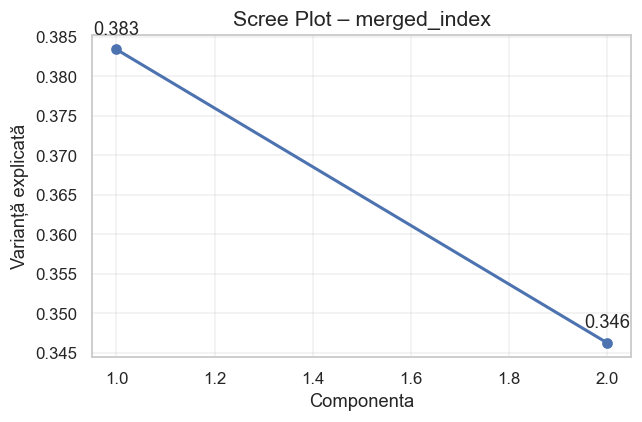

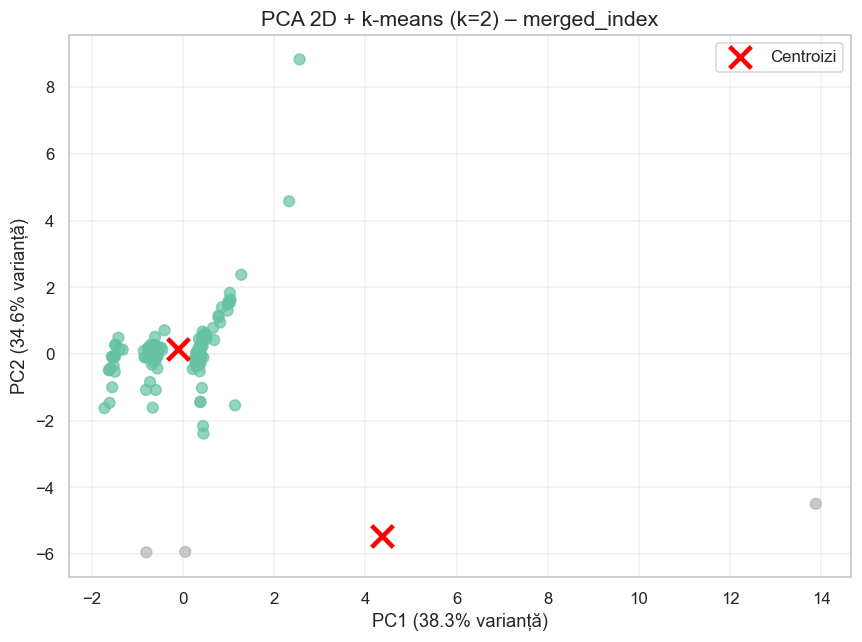


 Rezultate PCA:
   PC1 explică: 38.3% din varianță
   PC2 explică: 34.6% din varianță
   Total explicat: 73.0%

 Rezultate Clustering:
   Cluster 0: 119 puncte (97.5%)
   Cluster 1: 3 puncte (2.5%)


In [38]:
# 9️ PCA + k-means (k=2) pe merged_index ca exemplu
pca_df = merged_index.select_dtypes(include=[np.number]).dropna()

if pca_df.shape[1] >= 2:
    print(f"[INFO] PCA analysis pe {pca_df.shape[0]} rânduri și {pca_df.shape[1]} variabile numerice")
    
    # Standardizează datele
    scaler = StandardScaler()
    X_std = scaler.fit_transform(pca_df)
    
    # Aplică PCA
    pca = PCA(n_components=2)
    comps = pca.fit_transform(X_std)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=42).fit(comps)
    labels = kmeans.labels_

    # Scree plot (cu liniuță corectă)
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, "o-", linewidth=2, markersize=6)
    plt.title("Scree Plot – merged_index", fontsize=14)
    plt.xlabel("Componenta", fontsize=12)
    plt.ylabel("Varianță explicată", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Adaugă procentaje pe grafic
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        plt.annotate(f'{ratio:.3f}', 
                    (i+1, ratio), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "pca_scree_merged_index.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2D scatter cu clustering
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(comps[:, 0], comps[:, 1], 
                         c=labels, 
                         cmap='Set2', 
                         alpha=0.7, 
                         s=50)
    
    plt.title("PCA 2D + k-means (k=2) – merged_index", fontsize=14)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} varianță)", fontsize=12)
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} varianță)", fontsize=12)
    
    # Adaugă centroizii clusterelor
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], 
               c='red', marker='x', s=200, linewidths=3, label='Centroizi')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "pca_kmeans_merged_index.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Afișează statistici PCA
    print(f"\n Rezultate PCA:")
    print(f"   PC1 explică: {pca.explained_variance_ratio_[0]:.1%} din varianță")
    print(f"   PC2 explică: {pca.explained_variance_ratio_[1]:.1%} din varianță")
    print(f"   Total explicat: {sum(pca.explained_variance_ratio_):.1%}")
    
    print(f"\n Rezultate Clustering:")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(f"   Cluster {cluster}: {count} puncte ({count/len(labels):.1%})")

else:
    print(f"[WARNING] Nu sunt suficiente variabile numerice pentru PCA ({pca_df.shape[1]} disponibile)")

In [39]:
# %%
# 10️ Smoke‑tests finale
assert all(d.shape[0] > 0 for d,_,_ in eda_targets), "Cel puțin un DataFrame este gol!"
print("Smoke tests passed – Advanced viz incluse")

Smoke tests passed – Advanced viz incluse
